In [ ]:
# @title 1. Instalação e Importação das Bibliotecas
# Instalação das dependências (apenas primeira execução)
# !pip install yfinance pywavelets scikit-learn tensorflow numpy matplotlib seaborn optuna --quiet

import sys
sys.path.insert(0, '../..')  # Adiciona o diretório raiz ao path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)

# Importação dos módulos locais (agora em LearnableWaveletLayer/utils/)
from utils.data_utils import download_data, load_data_from_csv
from utils.features import create_features, create_sequences
from utils.labeling import get_daily_vol, triple_barrier_labeling, apply_labeling
from utils.model import create_cnn_lstm_model, create_model_for_tuning
from utils.validation import PurgedKFold, create_train_test_split
from utils.evaluation import (
    calculate_financial_metrics, 
    plot_labels_on_price, 
    plot_confusion_matrix,
    plot_cumulative_returns,
    print_classification_report,
    print_financial_metrics
)

print("✓ Bibliotecas e módulos importados com sucesso!")

Bibliotecas instaladas e importadas com sucesso!


/Users/fteodoro/LearnableWaveletLayer/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# @title 2. Configuração e Parâmetros
# Configurações do experimento
MAIN_TICKER = 'VALE3.SA'
DATA_PATH = '../../data/'
TIME_STEPS = 20
N_SPLITS = 5
OOS_YEARS = 2

# Período de dados
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(years=10)

print(f"Ticker: {MAIN_TICKER}")
print(f"Período: {start_date.date()} a {end_date.date()}")

In [ ]:
# @title 3. Download e Carregamento dos Dados
print(f"Baixando dados para {MAIN_TICKER}...")

try:
    raw_data = download_data(MAIN_TICKER, start_date, end_date)
    raw_data.to_csv(f"{DATA_PATH}{MAIN_TICKER}.csv")
    print(f"✓ Dados salvos em {DATA_PATH}{MAIN_TICKER}.csv")
except Exception as e:
    print(f"Download falhou: {e}. Carregando do CSV...")
    raw_data = load_data_from_csv(f"{DATA_PATH}{MAIN_TICKER}.csv")

print(f"\nShape: {raw_data.shape}")
print(raw_data.head())

Baixando dados para VALE3.SA...
Dados de VALE3.SA salvos em data/VALE3.SA.csv


In [ ]:
# @title 4. Criação de Features
print("Criando features técnicas e de processamento de sinal...")

full_feature_df = create_features(raw_data)
full_feature_df.fillna(method='bfill', inplace=True)
full_feature_df.dropna(inplace=True)

print(f"✓ Features criadas: {full_feature_df.shape[1]} colunas")
print(f"✓ Amostras: {len(full_feature_df)}")
print(f"\nColunas: {list(full_feature_df.columns)}")

ValueError: 'Date' is not in list

In [ ]:
# Visualização do DataFrame
full_feature_df.tail(10)

,Close,High,Low,Open,Volume,SMA_20,EMA_20,RSI_14,MACD_12_26_9,MACDs_12_26_9,...,BBM_20_2.0,BBU_20_2.0,BBL_20_2.0,fft_smoothed,wavelet_denoised,wavelet_coeff_0,wavelet_coeff_1,wavelet_coeff_2,wavelet_coeff_3,wavelet_coeff_4
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,9.434410,9.524161,9.043729,9.254908,8740700,9.360497,9.434410,43.142463,0.000000,0.000000,...,9.360497,10.644106,8.076888,30.484253,9.585575,38.947646,-0.049567,0.390073,0.016245,0.046702
2015-08-03,9.286584,9.471365,9.133479,9.402732,4459200,9.360497,9.420331,43.142463,-0.011792,-0.002358,...,9.360497,10.644106,8.076888,26.014341,9.578237,38.936445,-0.206771,1.243592,0.141927,0.026477
2015-08-04,9.555837,9.666705,9.460806,9.460806,3890900,9.360497,9.433237,43.142463,0.000582,-0.001770,...,9.360497,10.644106,8.076888,21.749228,9.615779,38.727535,-0.578461,-0.298024,0.593382,0.169281
2015-08-05,10.036268,10.178814,9.846207,9.846207,7956400,9.360497,9.490668,43.142463,0.048595,0.008303,...,9.360497,10.644106,8.076888,17.817062,9.696446,38.868858,-2.083854,0.005091,-0.152499,0.382487
2015-08-06,10.337200,10.448070,9.856769,9.904284,10318000,9.360497,9.571290,43.142463,0.109664,0.028575,...,9.360497,10.644106,8.076888,14.326775,9.638100,39.262839,2.567202,-0.427181,-0.045726,0.118145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-24,56.529999,57.290001,56.290001,56.939999,21651200,54.937000,55.001571,56.425105,0.907931,0.661069,...,54.937000,57.583181,52.290819,51.027416,55.809862,125.483685,1.093474,-2.444094,-0.552876,-0.422563
2025-07-25,55.700001,56.279999,55.270000,56.180000,21918900,55.078500,55.068088,56.316300,0.847784,0.698412,...,55.078500,57.556616,52.600384,47.596184,55.218927,139.084913,-2.422535,-1.192793,-0.204485,0.377761
2025-07-28,55.160000,55.320000,54.639999,54.939999,19175100,55.204000,55.076842,52.705213,0.747922,0.708314,...,55.204000,57.402759,53.005242,43.708709,54.610057,134.067860,-0.088754,0.429239,1.069554,-0.853021


In [ ]:
# @title 5. Rotulagem com Triple Barrier Method
print("Aplicando rotulagem Triple Barrier...")

# Calcula volatilidade e aplica rotulagem
final_df = apply_labeling(
    full_feature_df, 
    pt_sl=[1.5, 1.5], 
    min_ret=0.001, 
    num_days=10
)

print(f"\n✓ Rotulagem concluída: {len(final_df)} amostras")
print("\nDistribuição dos Rótulos:")
print(final_df['label'].value_counts().sort_index())


Distribuição dos Rótulos (Barreira Tripla):
label
 1.0    569
-1.0    485
 0.0    354
Name: count, dtype: int64


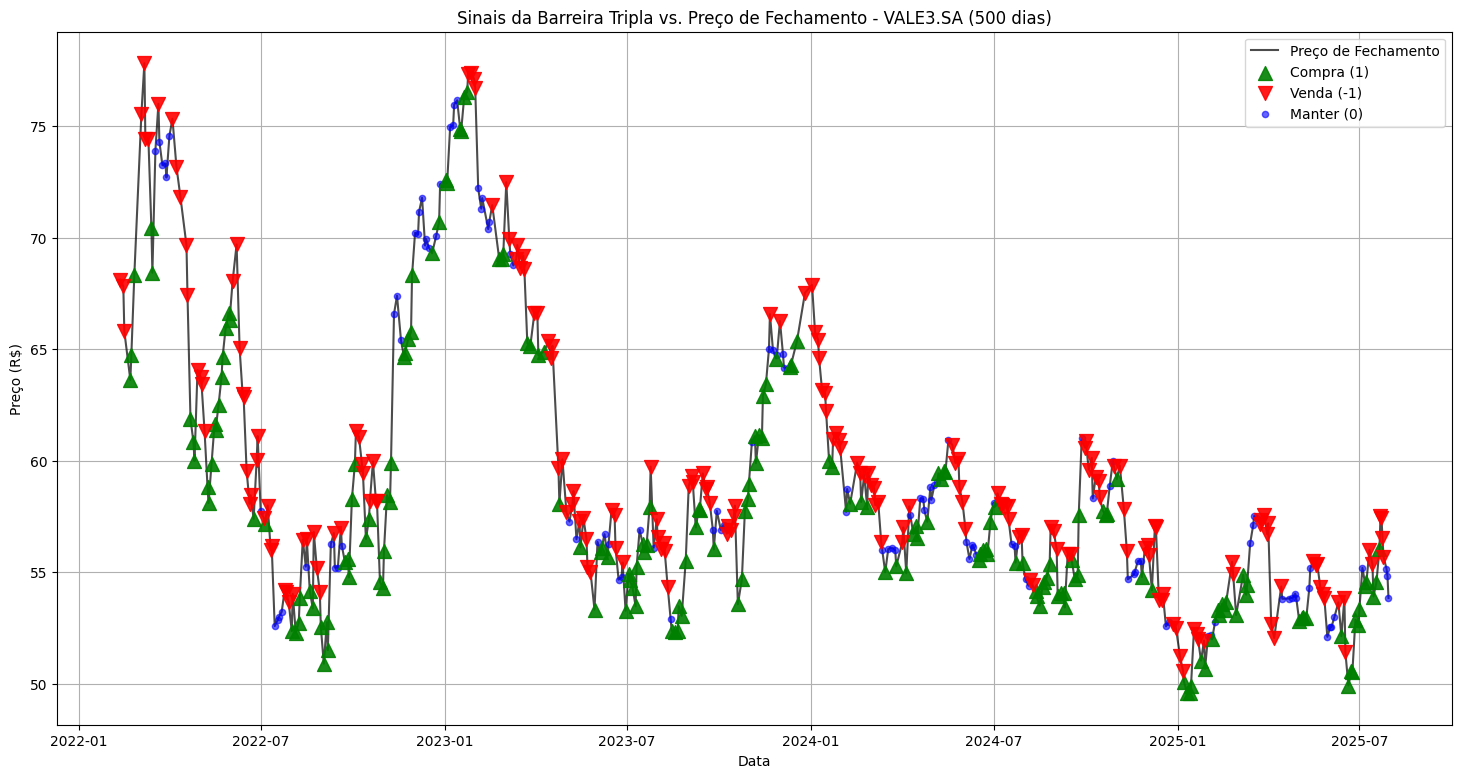

In [ ]:
# @title 5.1. Visualização dos Rótulos na Série de Preços
plot_labels_on_price(final_df, MAIN_TICKER, n_points=500)

In [ ]:
# @title 6. Divisão de Dados In-Sample e Out-of-Sample
df_in_sample, df_oos_test = create_train_test_split(final_df, oos_years=OOS_YEARS)

print(f"Período total: {final_df.index.min().date()} a {final_df.index.max().date()}")
print(f"\nIn-Sample (Treino/Validação):")
print(f"  Período: {df_in_sample.index.min().date()} a {df_in_sample.index.max().date()}")
print(f"  Amostras: {len(df_in_sample)}")
print(f"\nOut-of-Sample (Teste Final):")
print(f"  Período: {df_oos_test.index.min().date()} a {df_oos_test.index.max().date()}")
print(f"  Amostras: {len(df_oos_test)}")

Período total dos dados: 2015-08-04 a 2025-07-30
Período In-Sample (Treino/Validação): 2015-08-04 a 2023-07-28 (1118 amostras)
Período Out-of-Sample (Teste Final): 2023-07-31 a 2025-07-30 (290 amostras)


In [ ]:
# @title 7. Preparação para Validação Cruzada Purged K-Fold
# Prepara features e labels para In-Sample
X_is = df_in_sample.drop(['label', 'ret', 'trgt'], axis=1)
y_is = df_in_sample['label']
y_mapped_is = y_is.map({-1: 0, 0: 1, 1: 2})

# Cria série t1 para o purged k-fold (horizonte de 10 dias)
t1_series_is = df_in_sample.index + pd.Timedelta(days=10)
t1_series_is = pd.Series(t1_series_is, index=df_in_sample.index)

# Instancia o validador
purged_kfold = PurgedKFold(n_splits=N_SPLITS, t1=t1_series_is, pct_embargo=0.01)

print(f"✓ PurgedKFold configurado com {N_SPLITS} dobras")
print(f"✓ Features: {X_is.shape[1]} colunas")
print(f"✓ Amostras In-Sample: {len(X_is)}")


Validador PurgedKFold instanciado para dados In-Sample.


In [ ]:
# @title 8. Loop de Validação Cruzada (In-Sample)
all_true_labels_cv, all_pred_labels_cv, all_returns_cv = [], [], []

fold = 0
for train_idx, test_idx in purged_kfold.split(X_is, y_mapped_is):
    fold += 1
    print(f"\n{'='*50}")
    print(f"Processando Dobra {fold}/{N_SPLITS}")
    print(f"{'='*50}")
    
    if len(train_idx) == 0 or len(test_idx) == 0:
        print("⚠ Dobra vazia, pulando...")
        continue

    # Separa treino e teste
    X_train, X_test = X_is.iloc[train_idx], X_is.iloc[test_idx]
    y_train, y_test = y_mapped_is.iloc[train_idx], y_mapped_is.iloc[test_idx]
    
    print(f"  Treino: {len(X_train)} | Teste: {len(X_test)}")

    # Escalonamento
    scaler = RobustScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    # Cria sequências
    X_train_seq, y_train_seq, _ = create_sequences(X_train_scaled, y_train, TIME_STEPS)
    X_test_seq, y_test_seq, y_test_indices = create_sequences(X_test_scaled, y_test, TIME_STEPS)

    if X_train_seq.shape[0] == 0 or X_test_seq.shape[0] == 0:
        print("⚠ Dados insuficientes para sequências. Pulando...")
        continue

    # Treina modelo
    y_train_cat = to_categorical(y_train_seq, num_classes=3)
    model = create_cnn_lstm_model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), num_classes=3)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ModelCheckpoint(f'best_model_fold_{fold}.keras', monitor='val_loss', save_best_only=True, verbose=0)
    ]

    model.fit(X_train_seq, y_train_cat, epochs=100, batch_size=32, verbose=0, 
              validation_split=0.1, callbacks=callbacks)

    # Previsões
    predictions = np.argmax(model.predict(X_test_seq, verbose=0), axis=1)
    pred_labels_original = pd.Series(predictions).map({0: -1, 1: 0, 2: 1}).values
    true_labels_original = pd.Series(y_test_seq).map({0: -1, 1: 0, 2: 1}).values
    
    # Acumula resultados
    all_pred_labels_cv.extend(pred_labels_original)
    all_true_labels_cv.extend(true_labels_original)
    
    test_returns = df_in_sample.loc[y_test_indices, 'ret']
    strategy_returns = test_returns * pred_labels_original
    all_returns_cv.extend(strategy_returns)
    
    fold_acc = accuracy_score(true_labels_original, pred_labels_original)
    print(f"  ✓ Acurácia da Dobra: {fold_acc:.4f}")

print("\n" + "="*50)
print("✓ Validação Cruzada In-Sample Concluída")
print("="*50)

In [ ]:
# @title 9. Treinamento do Modelo Final (todos os dados In-Sample)
print("Treinando Modelo Final com todos os dados In-Sample...")

# Preparação
X_is_full = df_in_sample.drop(['label', 'ret', 'trgt'], axis=1)
y_is_full_mapped = df_in_sample['label'].map({-1: 0, 0: 1, 1: 2})

# Escalonamento final
final_scaler = RobustScaler()
X_is_scaled_full = pd.DataFrame(
    final_scaler.fit_transform(X_is_full), 
    index=X_is_full.index, 
    columns=X_is_full.columns
)

# Sequências
X_final_train_seq, y_final_train_seq, _ = create_sequences(X_is_scaled_full, y_is_full_mapped, TIME_STEPS)
y_final_train_cat = to_categorical(y_final_train_seq, num_classes=3)

# Treina modelo final
final_model = create_cnn_lstm_model(
    input_shape=(X_final_train_seq.shape[1], X_final_train_seq.shape[2]), 
    num_classes=3
)

print(f"Treinando com {X_final_train_seq.shape[0]} amostras...")
final_model.fit(X_final_train_seq, y_final_train_cat, epochs=50, batch_size=16, verbose=1)

# Salva modelo
final_model.save('final_production_model.keras')
print("\n✓ Modelo final salvo como 'final_production_model.keras'")


--- Treinando o Modelo Final ---
Treinando modelo final com 1098 amostras...
Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3571 - loss: 1.7761
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4040 - loss: 1.5837
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4109 - loss: 1.4812
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4587 - loss: 1.3875
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4522 - loss: 1.3129
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4623 - loss: 1.2699
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4679 - loss: 1.2402
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4548 - loss: 1.2243
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4755 - loss: 1.2040
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4964 - loss: 1.1789
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5027 - loss: 1.1



--- AVALIAÇÃO DA VALIDAÇÃO CRUZADA (IN-SAMPLE) ---
Acurácia Geral (CV): 0.3846

Relatório de Classificação (CV):
              precision    recall  f1-score   support

 Vender (-1)       0.25      0.20      0.22       185
  Manter (0)       0.00      0.00      0.00       158
 Comprar (1)       0.43      0.74      0.54       268

    accuracy                           0.38       611
   macro avg       0.23      0.31      0.25       611
weighted avg       0.26      0.38      0.31       611



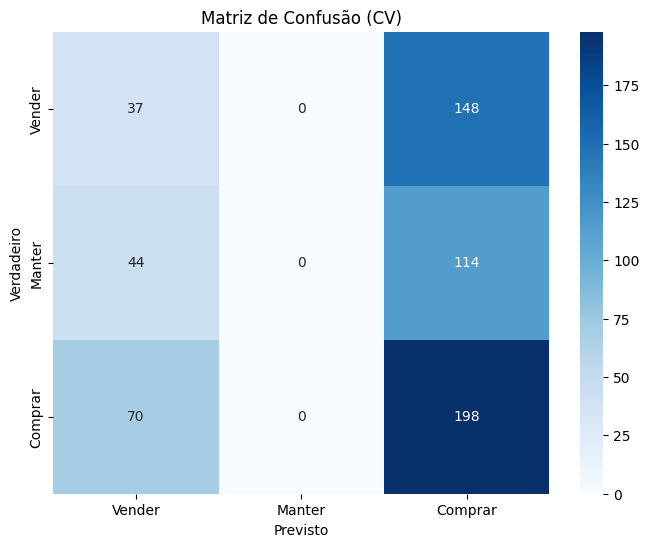


Métricas Financeiras (CV):
Sharpe Ratio: 0.6799
Sortino Ratio: 1.1446
Maximum Drawdown: -85.1283%
Calmar Ratio: 0.5998


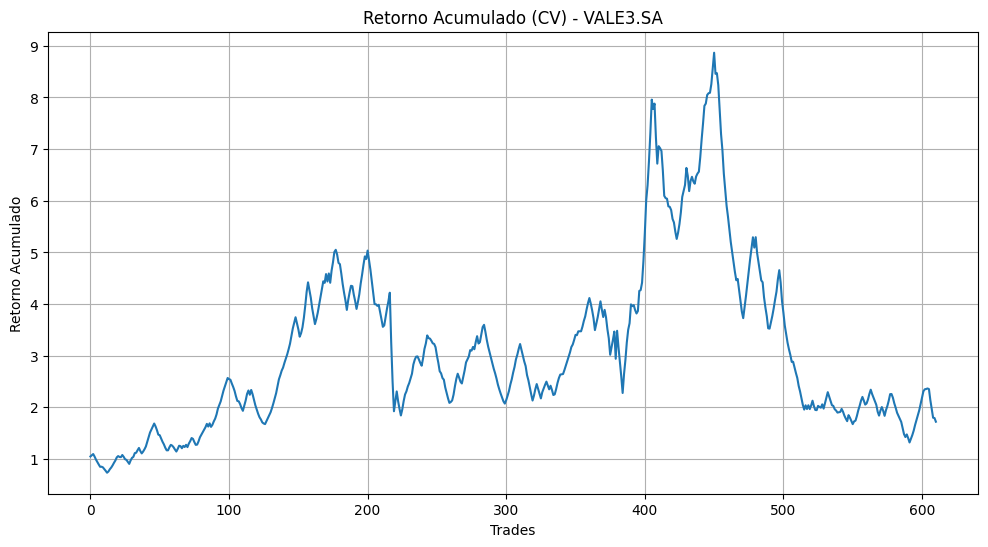

In [ ]:
# @title 10. Avaliação da Validação Cruzada (In-Sample)
print("\n" + "="*60)
print("AVALIAÇÃO DA VALIDAÇÃO CRUZADA (IN-SAMPLE)")
print("="*60)

if all_true_labels_cv:
    # Métricas de classificação
    print_classification_report(all_true_labels_cv, all_pred_labels_cv, "Classificação CV")
    
    # Matriz de confusão
    plot_confusion_matrix(all_true_labels_cv, all_pred_labels_cv, "Matriz de Confusão (CV)")

    # Métricas financeiras
    financial_metrics_cv = calculate_financial_metrics(all_returns_cv)
    print_financial_metrics(financial_metrics_cv, "Métricas Financeiras CV")
    
    # Gráfico de retornos
    plt.figure(figsize=(12, 6))
    financial_metrics_cv['Cumulative Returns'].plot()
    plt.title(f'Retorno Acumulado (CV) - {MAIN_TICKER}')
    plt.xlabel('Trades')
    plt.ylabel('Retorno Acumulado')
    plt.grid(True)
    plt.show()
else:
    print("⚠ Nenhuma previsão gerada na Validação Cruzada.")



--- AVALIAÇÃO FINAL NO CONJUNTO DE TESTE OUT-OF-SAMPLE (OOS) ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Acurácia Geral (OOS): 0.3481

Relatório de Classificação (OOS):
              precision    recall  f1-score   support

 Vender (-1)       0.39      0.36      0.38       107
  Manter (0)       0.33      0.09      0.14        69
 Comprar (1)       0.32      0.52      0.40        94

    accuracy                           0.35       270
   macro avg       0.35      0.32      0.30       270
weighted avg       0.35      0.35      0.32       270



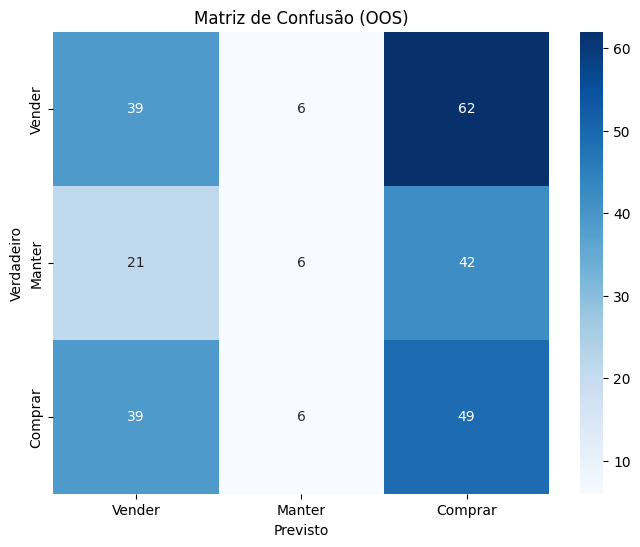


Métricas Financeiras (OOS):
Sharpe Ratio: -0.9108
Sortino Ratio: -2.0125
Maximum Drawdown: -67.4597%
Calmar Ratio: -0.6209


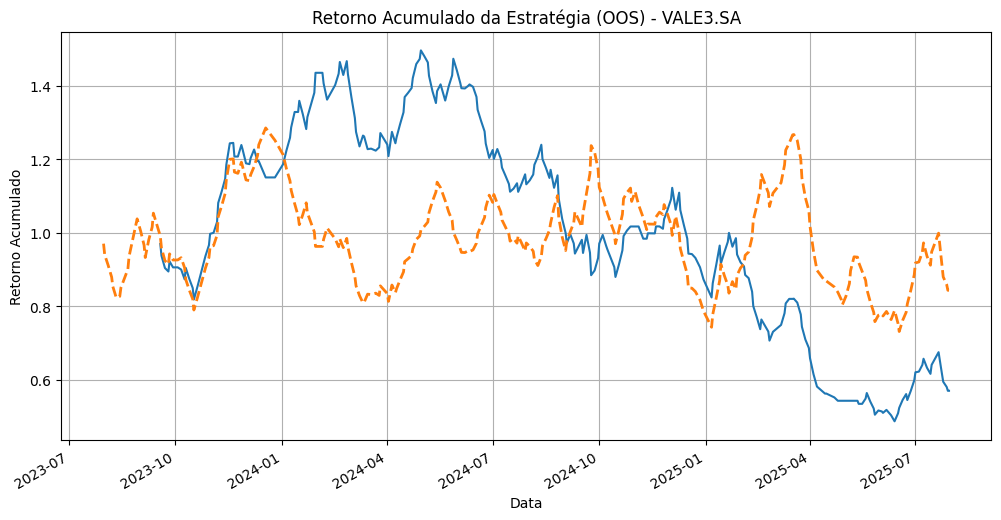

In [ ]:
# @title 11. Avaliação Final Out-of-Sample (OOS)
print("\n" + "="*60)
print("AVALIAÇÃO FINAL OUT-OF-SAMPLE (OOS)")
print("="*60)

# Preparação dos dados OOS
X_oos = df_oos_test.drop(['label', 'ret', 'trgt'], axis=1)
y_oos_mapped = df_oos_test['label'].map({-1: 0, 0: 1, 1: 2})

# Usa o scaler ajustado nos dados de treino
X_oos_scaled = pd.DataFrame(
    final_scaler.transform(X_oos), 
    index=X_oos.index, 
    columns=X_oos.columns
)

# Sequências OOS
X_oos_seq, y_oos_seq, y_oos_indices = create_sequences(X_oos_scaled, y_oos_mapped, TIME_STEPS)

if X_oos_seq.shape[0] > 0:
    # Carrega modelo e faz previsões
    production_model = load_model('final_production_model.keras')
    predictions_oos = np.argmax(production_model.predict(X_oos_seq, verbose=0), axis=1)

    # Converte labels
    pred_labels_oos = pd.Series(predictions_oos).map({0: -1, 1: 0, 2: 1}).values
    true_labels_oos = pd.Series(y_oos_seq).map({0: -1, 1: 0, 2: 1}).values

    # Métricas de classificação OOS
    print_classification_report(true_labels_oos, pred_labels_oos, "Classificação OOS")
    plot_confusion_matrix(true_labels_oos, pred_labels_oos, "Matriz de Confusão (OOS)")

    # Métricas financeiras OOS
    oos_returns = df_oos_test.loc[y_oos_indices, 'ret']
    strategy_returns_oos = oos_returns * pred_labels_oos
    financial_metrics_oos = calculate_financial_metrics(strategy_returns_oos)
    print_financial_metrics(financial_metrics_oos, "Métricas Financeiras OOS")

    # Comparação com Buy and Hold
    plt.figure(figsize=(12, 6))
    financial_metrics_oos['Cumulative Returns'].plot(label='Estratégia')
    buy_hold_returns = (1 + df_oos_test['ret']).cumprod()
    buy_hold_returns.plot(label='Buy and Hold', linestyle='--', linewidth=2)
    plt.title(f'Retorno Acumulado (OOS) - {MAIN_TICKER}')
    plt.xlabel('Data')
    plt.ylabel('Retorno Acumulado')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠ Dados insuficientes no conjunto Out-of-Sample.")